In [2]:
# this block loads a dataset from tensorflow repository
# and also it include tensorflow lib
import tensorflow_datasets as tfds
import tensorflow as tf

In [3]:
print(tf.__version__)

2.10.0


In [4]:
# now it loads data for training and data for testing, also it loads info about
# this dataset
train_data, info = tfds.load("fashion_mnist", with_info=True, split="train")
test_data = tfds.load("fashion_mnist", split="test")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\voldo\tensorflow_datasets\fashion_mnist\3.0.1.incomplete03I6JX\fashion_mnist-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\voldo\tensorflow_datasets\fashion_mnist\3.0.1.incomplete03I6JX\fashion_mnist-test.tfrecord*…

Dataset fashion_mnist downloaded and prepared to C:\Users\voldo\tensorflow_datasets\fashion_mnist\3.0.1. Subsequent calls will reuse this data.


In [5]:
# give names of each in the dataset
names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [6]:
# import different stuff for plotting
from matplotlib import rcParams
from matplotlib import pyplot as plt

rcParams["figure.figsize"] = [10, 10]
rcParams['xtick.labelbottom'] = False

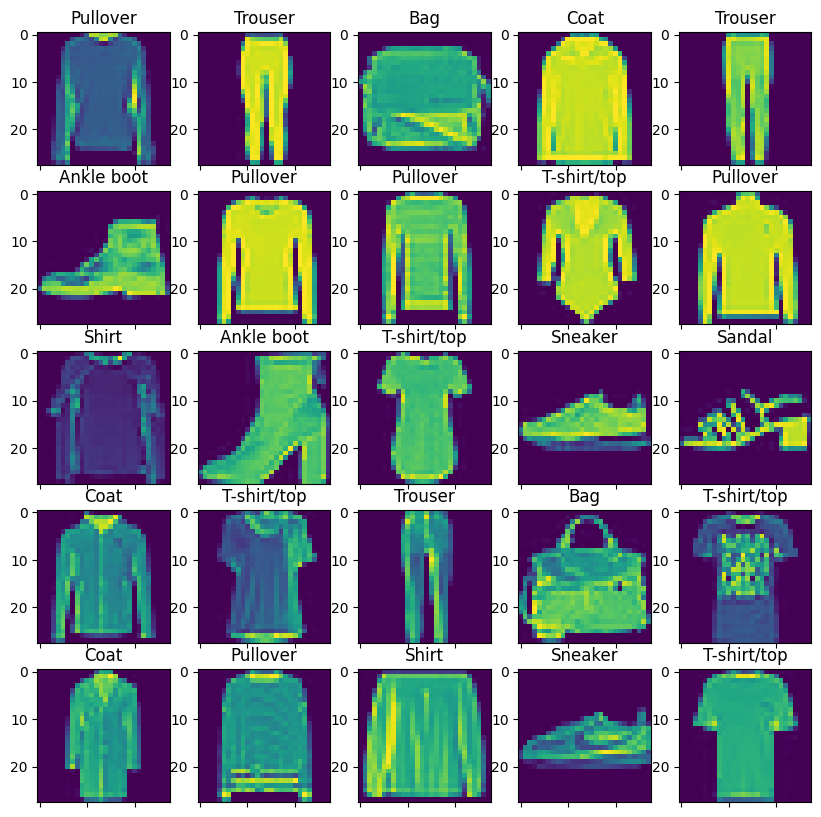

In [7]:
# finaly plot it on the
for idx, elem in enumerate(train_data.take(25)):
    plt.subplot(5, 5, idx + 1, title=names[elem['label'].numpy()])
    plt.imshow(elem['image'][:, :, 0])

In [9]:
# this function does the simplest pre-processing, it just unzip loaded data
# in more comfortable way
def preprocessing(data):
    x = tf.reshape(data["image"], [-1])
    y = data["label"]
    return x, y


def preprocessing_with_norm(data):
    x = tf.reshape(data["image"], [-1]) / 255
    y = data["label"]
    return x, y

In [10]:
import tensorflow_addons as tfa
from random import seed
from random import randint
from random import random

seed(1)

In [11]:
def do_augmentation(image):
    rand_augment_code = randint(0, 28)
    angle = 0.2 * random()
    shear = 0.15 * random()
    if rand_augment_code < 4:
        x = tf.image.random_flip_left_right(image)
    elif rand_augment_code < 8:
        x = tfa.image.rotate(image, angle, fill_mode="constant", fill_value=0)
    elif rand_augment_code < 12:
        x = tfa.image.rotate(image, -angle, fill_mode="constant", fill_value=0)
    elif rand_augment_code < 16:
        x = tfa.image.shear_x(image, shear)
    elif rand_augment_code < 20:
        x = tfa.image.shear_y(image, -shear)
    elif rand_augment_code < 24:
        x = tfa.image.shear_y(image, shear)
    else:
        x = tfa.image.shear_y(image, -shear)
    return x


def preprocessing_with_augmentaion(data):
    x = do_augmentation(data["image"])
    x = tf.reshape(x, [-1])
    y = data["label"]
    return x, y


def preprocessing_with_aug_norm(data):
    x = do_augmentation(data["image"])
    x = tf.reshape(x, [-1]) / 255
    y = data["label"]
    return x, y

In [12]:
# pre-process the train and the test data

train_data_pre_1 = train_data.map(preprocessing_with_aug_norm)
train_data_pre_2 = train_data.map(preprocessing_with_norm)
train_data_pre = train_data_pre_1.concatenate(train_data_pre_2)

test_data_pre = test_data.map(preprocessing_with_norm)

batch_size = 64
train_data_pre = train_data_pre.batch(batch_size)
test_data_pre = test_data_pre.batch(batch_size)

In [13]:
# this function defines base model (!!!WARNING, in the task I can't modify it).
# then it creates model and print model summary
# Cause we have the input 28*28*1 (gray_scale) = 784 - here is an input layer

def base_model():
    inputs = tf.keras.Input(shape=(784,))
    x = tf.keras.layers.Dense(64, activation='relu')(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [14]:
model = base_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


In [15]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

@tf.function
def regularization_l1(trainable_variables, var_lambda=0.01):
    reg = 0.0
    for x in trainable_variables:
        reg = reg + tf.math.reduce_sum(tf.math.abs(x))
    return var_lambda * reg

@tf.function
def regularization_l2(trainable_variables, var_lambda=0.01):
    reg = 0.0
    for x in trainable_variables:
        reg = reg + tf.math.reduce_sum(tf.math.square(x))
    reg = tf.math.sqrt(reg)
    return var_lambda * reg

@tf.function
def regularization_l1_l2(trainable_variables, var_lambda_l1=0.01, var_lambda_l2=0.01):
    reg_l1 = regularization_l1(trainable_variables, var_lambda=var_lambda_l1)
    reg_l2 = regularization_l2(trainable_variables, var_lambda=var_lambda_l2)
    return reg_l1 + reg_l2



@tf.function
def train_step(x, y, lr=0.0005):
    with tf.GradientTape() as tape:
        pred = model(x)
        loss = loss_object(y, pred)
        regl = regularization_l2(model.trainable_variables)
        gradients = tape.gradient(loss + regl, model.trainable_variables)

        new_weights = []
        for w, grad in zip(model.trainable_variables, gradients):
            new_weights.append(w - lr * grad)

        for v, w in zip(model.trainable_variables, new_weights):
            v.assign(w)
    pred_nums = tf.math.argmax(pred, axis=1)
    equality = tf.math.equal(pred_nums, y)
    accuracy = tf.math.reduce_mean(tf.cast(equality, tf.float32))

    return loss, accuracy

In [16]:
import numpy as np

x_test = np.concatenate([x for x, y in test_data_pre], axis=0)
y_test = np.concatenate([y for x, y in test_data_pre], axis=0)

In [17]:
def calc_acc():
    pred = model.predict(x_test)
    acc = np.sum(np.argmax(pred, axis=-1) == y_test) / len(y_test)
    return acc

In [18]:
print("Show initial accuracity")
print("Test acc: ", calc_acc())

Show initial accuracity
313/313 [==============================] - 3s 2ms/step
Test acc:  0.1689


In [19]:
def schedule_lr(epoch_count, epoch):
    if epoch < epoch_count / 5:
        return 0.001
    elif epoch < 2 * epoch_count / 5:
        return 0.0009
    elif epoch < 3 * epoch_count / 5:
        return 0.0007
    elif epoch < 4 * epoch_count / 5:
        return 0.0008
    else:
        return 0.0005

In [20]:
from tqdm import tqdm

total_loss_acc_array = []

epoch_count = 50
count_batches = len(train_data_pre)
for epoch in range(epoch_count):
    lr = schedule_lr(epoch_count, epoch)
    total_loss = 0.0
    total_accuracy = 0.0
    print("\nEpoch {}:".format(str(epoch + 1) + "/" + str(epoch_count)))
    for step, (x, y) in enumerate(tqdm(train_data_pre)):
        training_result = train_step(x, y, lr=lr)
        total_loss = total_loss + training_result[0].numpy()
        total_accuracy = total_accuracy + training_result[1].numpy()
    total_loss = total_loss / count_batches
    total_accuracy = total_accuracy / count_batches
    total_loss_acc_array.append([epoch + 1, total_loss, total_accuracy])
    print("loss =", total_loss, " acc =", total_accuracy)


Epoch 1/50:


100%|██████████| 1875/1875 [00:10<00:00, 172.76it/s]


loss = 1.6243654537200927  acc = 0.5201833333333333

Epoch 2/50:


100%|██████████| 1875/1875 [00:09<00:00, 196.25it/s]


loss = 0.9574908948898315  acc = 0.6974083333333333

Epoch 3/50:


100%|██████████| 1875/1875 [00:10<00:00, 186.53it/s]


loss = 0.7781584789911906  acc = 0.7445666666666667

Epoch 4/50:


100%|██████████| 1875/1875 [00:09<00:00, 188.20it/s]


loss = 0.6969486569245656  acc = 0.7715916666666667

Epoch 5/50:


100%|██████████| 1875/1875 [00:09<00:00, 193.26it/s]


loss = 0.6476842881202698  acc = 0.7872

Epoch 6/50:


100%|██████████| 1875/1875 [00:09<00:00, 190.52it/s]


loss = 0.6137674603780111  acc = 0.7965333333333333

Epoch 7/50:


100%|██████████| 1875/1875 [00:10<00:00, 181.88it/s]


loss = 0.5887373865763347  acc = 0.8032

Epoch 8/50:


100%|██████████| 1875/1875 [00:10<00:00, 183.70it/s]


loss = 0.5694427825133006  acc = 0.8084166666666667

Epoch 9/50:


100%|██████████| 1875/1875 [00:10<00:00, 182.13it/s]


loss = 0.5540313903331756  acc = 0.8125333333333333

Epoch 10/50:


100%|██████████| 1875/1875 [00:10<00:00, 183.29it/s]


loss = 0.5413523167610168  acc = 0.816175

Epoch 11/50:


100%|██████████| 1875/1875 [00:10<00:00, 172.67it/s]


loss = 0.5310369184176127  acc = 0.8189583333333333

Epoch 12/50:


100%|██████████| 1875/1875 [00:09<00:00, 203.27it/s]


loss = 0.5226334710915883  acc = 0.8213333333333334

Epoch 13/50:


100%|██████████| 1875/1875 [00:10<00:00, 183.09it/s]


loss = 0.5151947994391124  acc = 0.8232583333333333

Epoch 14/50:


100%|██████████| 1875/1875 [00:10<00:00, 184.51it/s]


loss = 0.5085225078105926  acc = 0.825375

Epoch 15/50:


100%|██████████| 1875/1875 [00:10<00:00, 181.05it/s]


loss = 0.5024568583170573  acc = 0.8273916666666666

Epoch 16/50:


100%|██████████| 1875/1875 [00:10<00:00, 187.32it/s]


loss = 0.49690608615080517  acc = 0.8288833333333333

Epoch 17/50:


100%|██████████| 1875/1875 [00:10<00:00, 177.30it/s]


loss = 0.4918703573385874  acc = 0.8301083333333333

Epoch 18/50:


100%|██████████| 1875/1875 [00:10<00:00, 183.21it/s]


loss = 0.4872352083762487  acc = 0.8315333333333333

Epoch 19/50:


100%|██████████| 1875/1875 [00:10<00:00, 178.71it/s]


loss = 0.482932799633344  acc = 0.8328666666666666

Epoch 20/50:


100%|██████████| 1875/1875 [00:09<00:00, 197.46it/s]


loss = 0.47891474480628965  acc = 0.8343583333333333

Epoch 21/50:


100%|██████████| 1875/1875 [00:10<00:00, 173.34it/s]


loss = 0.4752845026731491  acc = 0.8356166666666667

Epoch 22/50:


100%|██████████| 1875/1875 [00:09<00:00, 193.45it/s]


loss = 0.47246835561593375  acc = 0.8365

Epoch 23/50:


100%|██████████| 1875/1875 [00:10<00:00, 183.29it/s]


loss = 0.4697949539343516  acc = 0.8375083333333333

Epoch 24/50:


100%|██████████| 1875/1875 [00:10<00:00, 175.52it/s]


loss = 0.4672351296186447  acc = 0.8382666666666667

Epoch 25/50:


100%|██████████| 1875/1875 [00:10<00:00, 175.60it/s]


loss = 0.4647700899998347  acc = 0.8390083333333334

Epoch 26/50:


100%|██████████| 1875/1875 [00:09<00:00, 189.13it/s]


loss = 0.46238546817302706  acc = 0.8396416666666666

Epoch 27/50:


100%|██████████| 1875/1875 [00:10<00:00, 179.37it/s]


loss = 0.4600637519041697  acc = 0.8403

Epoch 28/50:


100%|██████████| 1875/1875 [00:10<00:00, 180.90it/s]


loss = 0.45780678283373516  acc = 0.8410083333333334

Epoch 29/50:


100%|██████████| 1875/1875 [00:09<00:00, 190.26it/s]


loss = 0.45565923227469124  acc = 0.8417083333333333

Epoch 30/50:


100%|██████████| 1875/1875 [00:10<00:00, 179.03it/s]


loss = 0.45360800146261854  acc = 0.8425416666666666

Epoch 31/50:


100%|██████████| 1875/1875 [00:10<00:00, 179.29it/s]


loss = 0.45163303713798525  acc = 0.8432916666666667

Epoch 32/50:


100%|██████████| 1875/1875 [00:10<00:00, 174.54it/s]


loss = 0.44945832709471384  acc = 0.84425

Epoch 33/50:


100%|██████████| 1875/1875 [00:10<00:00, 180.04it/s]


loss = 0.44734936598936714  acc = 0.8450333333333333

Epoch 34/50:


100%|██████████| 1875/1875 [00:10<00:00, 175.56it/s]


loss = 0.4453101874430974  acc = 0.8456083333333333

Epoch 35/50:


100%|██████████| 1875/1875 [00:09<00:00, 194.84it/s]


loss = 0.4433384732723236  acc = 0.8464333333333334

Epoch 36/50:


100%|██████████| 1875/1875 [00:10<00:00, 185.67it/s]


loss = 0.4414281904220581  acc = 0.8471583333333333

Epoch 37/50:


100%|██████████| 1875/1875 [00:10<00:00, 183.45it/s]


loss = 0.43958037884235385  acc = 0.847875

Epoch 38/50:


100%|██████████| 1875/1875 [00:10<00:00, 183.58it/s]


loss = 0.4377888395229975  acc = 0.8487166666666667

Epoch 39/50:


100%|██████████| 1875/1875 [00:10<00:00, 185.11it/s]


loss = 0.4360403863032659  acc = 0.8492166666666666

Epoch 40/50:


100%|██████████| 1875/1875 [00:10<00:00, 181.14it/s]


loss = 0.4343471606016159  acc = 0.8498666666666667

Epoch 41/50:


100%|██████████| 1875/1875 [00:10<00:00, 186.22it/s]


loss = 0.43253729486465453  acc = 0.8503666666666667

Epoch 42/50:


100%|██████████| 1875/1875 [00:10<00:00, 186.52it/s]


loss = 0.43149357074896494  acc = 0.8506416666666666

Epoch 43/50:


100%|██████████| 1875/1875 [00:10<00:00, 185.48it/s]


loss = 0.4304884639342626  acc = 0.8510833333333333

Epoch 44/50:


100%|██████████| 1875/1875 [00:10<00:00, 187.04it/s]


loss = 0.42950066436131795  acc = 0.8515166666666667

Epoch 45/50:


100%|██████████| 1875/1875 [00:10<00:00, 181.35it/s]


loss = 0.42852957174777984  acc = 0.851875

Epoch 46/50:


100%|██████████| 1875/1875 [00:09<00:00, 193.80it/s]


loss = 0.42757645710309344  acc = 0.8521833333333333

Epoch 47/50:


100%|██████████| 1875/1875 [00:11<00:00, 165.32it/s]


loss = 0.426633950082461  acc = 0.8525333333333334

Epoch 48/50:


100%|██████████| 1875/1875 [00:11<00:00, 170.28it/s]


loss = 0.4257068189382553  acc = 0.8529666666666667

Epoch 49/50:


100%|██████████| 1875/1875 [00:10<00:00, 171.96it/s]


loss = 0.424789839498202  acc = 0.8532916666666667

Epoch 50/50:


100%|██████████| 1875/1875 [00:10<00:00, 178.65it/s]

loss = 0.4238886698325475  acc = 0.85375


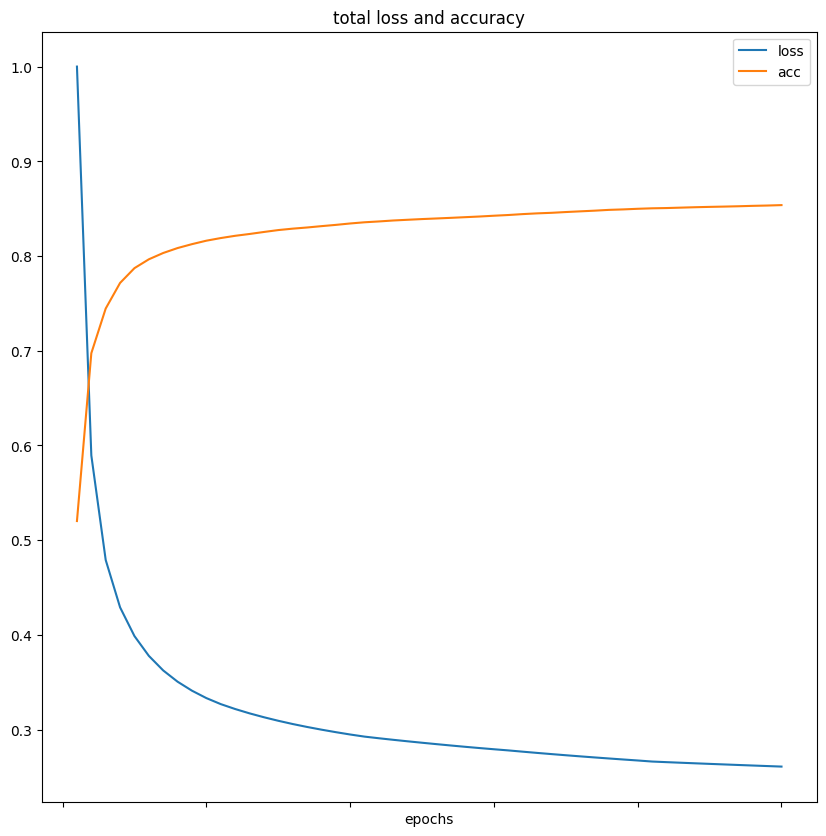

In [21]:
import matplotlib.pyplot as plt

epoch_array = []
loss_array = []
acc_array = []
for inx in range(len(total_loss_acc_array)):
    epoch_array.append(total_loss_acc_array[inx][0])
    loss_array.append(total_loss_acc_array[inx][1])
    acc_array.append(total_loss_acc_array[inx][2])

max_loss = max(loss_array)
loss_array = loss_array / max_loss

plt.plot(epoch_array, loss_array, label="loss")
plt.plot(epoch_array, acc_array, label="acc")
plt.xlabel("epochs")
plt.title("total loss and accuracy")

plt.legend()
plt.show()

In [22]:
print("\n\nShow last accuracity")
print("Test acc: ", calc_acc())



Show last accuracity
313/313 [==============================] - 0s 1ms/step
Test acc:  0.8383


In [23]:
from matplotlib import rcParams
from matplotlib import pyplot as plt

rcParams["figure.figsize"] = [10, 10]
rcParams['xtick.labelbottom'] = False

313/313 [==============================] - 0s 1ms/step


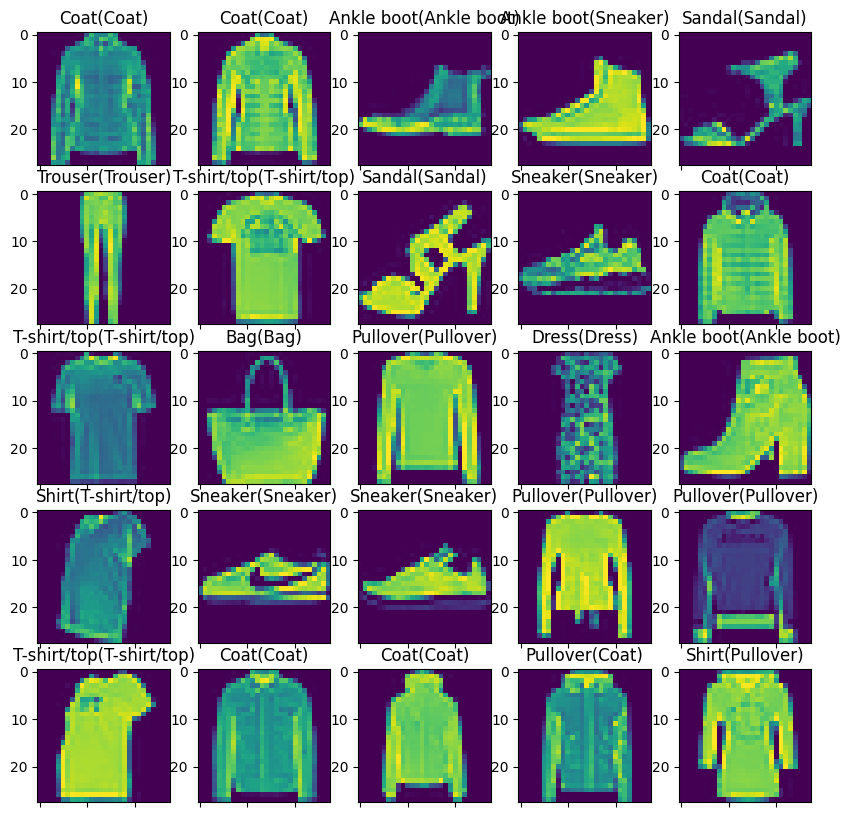

In [24]:
# finally plot it on the

test_pred = model.predict(x_test)

for idx, elem in enumerate(test_data.take(25)):
    pred_idx = np.argmax(test_pred[idx])
    true_idx = y_test[idx]
    plt.subplot(5, 5, idx + 1, title=(names[pred_idx] + "(" + names[true_idx] + ")"))
    plt.imshow(elem['image'][:, :, 0])

313/313 [==============================] - 0s 1ms/step


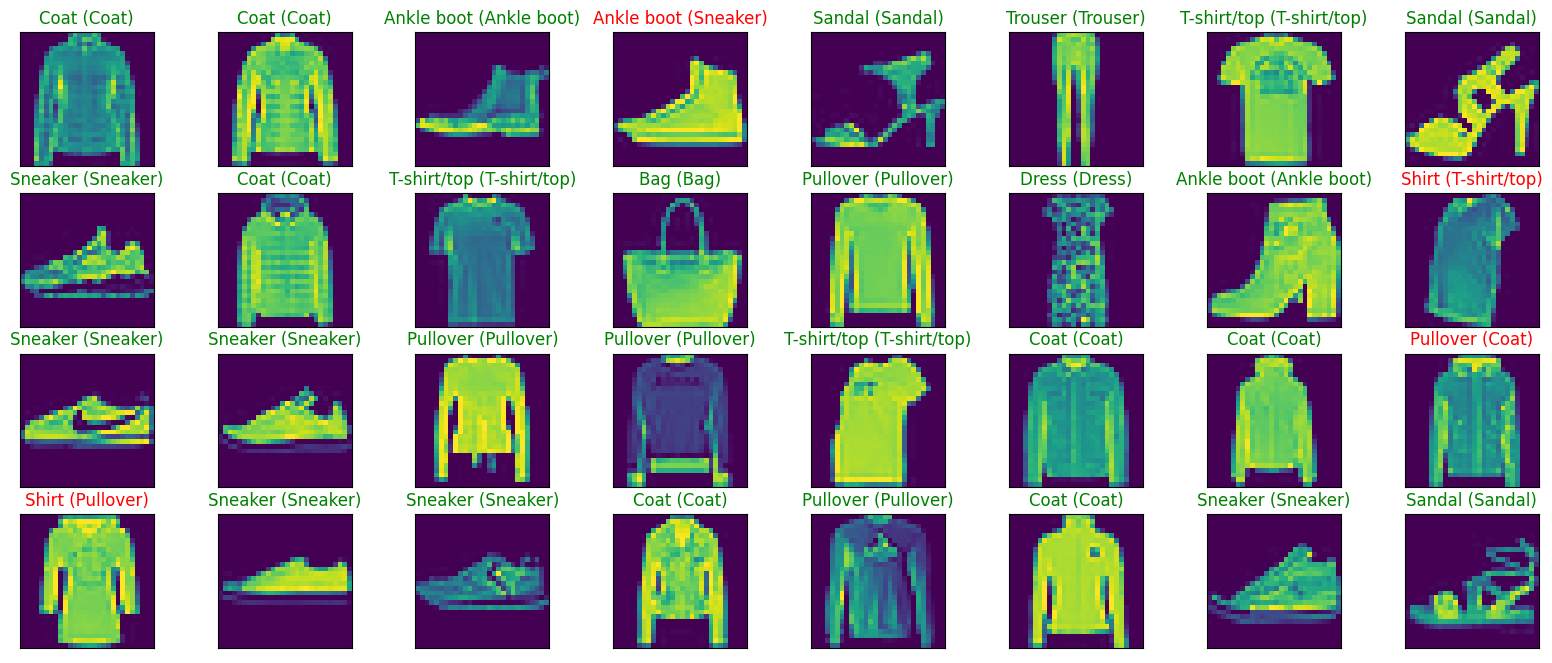

In [25]:
from matplotlib import pyplot

test_pred = model.predict(x_test)
fig = pyplot.figure(figsize=(20, 8))

for idx, elem in enumerate(test_data.take(32)):
    ax = fig.add_subplot(4, 8, idx + 1, xticks=[], yticks=[])
    ax.imshow(elem['image'][:, :, 0])
    pred_idx = np.argmax(test_pred[idx])
    true_idx = y_test[idx]
    ax.set_title("{} ({})".format(names[pred_idx], names[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))
pyplot.show()